# 0. Introduction to Facebook Prophet

<img src="Images/Prophet_image.png">
<center style="color: gray; font-style: italic">Forecasting on Peyton Manning's Wikipedia page views using Facebook Prophet.</center>
<div style="visibility:hidden">https://facebook.github.io/prophet/docs/quick_start.html</div>

### In this Notebook, you will...

1. Get familiar with what Facebook Prophet is, what it's strengths and limitations are
2. Learn how to implement a basic Prophet model on manufactured data
3. Learn how Prophet handles seasonality, and how custom seasonalities can be added
4. Learn what the Fourier order does in Prophet
5. Learn how to deploy your Prophet model, load and save it, as well as evaluate it
6. More complex problems...

Please note that in-text citations will be cited appropriately. Images will not be cited within the references; instead their links can be found by double-clicking the relevant cells, and finding the HTML tags that have links.

<div style="color:red">what about multivsriate problems? (extra regressor!)</div>

# What is Facebook Prophet?

Facebook Prophet is the industry standard for forecasting time-series data due to it's ease of use and similarity with other common data science libraries, such as sklearn [1]. It works very well with seasonal data, and is robust to missing data and outliers [2]. In fact, Prophet was designed to reduce the data science skills gap by automating time-series forecasts [3].

### What makes Prophet so powerful?

Prophet is great because it's fairly easy to get started with and it handles things such as seasonality, trends and missing data very well. For those starting their journey with time-series data analysis, Prophet is great for it provides an *easy* way to make predictions without the need for an 'expert' knowledge in either the industry where it is applied or even data science. That said though, a true expert (which hopefully you'll all be by the end of the course!) will be able to tune it's parameters to solve problems of different difficulties.

The Prophet model works best when you have data that contains **strong** seasonalities and **lots** of historical data.

# Basic implementation

For the purposes of this Module, I've tried had to find datasets other than those available on the Prophet webpage, hoping to introduce you to different problems that have different challenges. That said, where I teach in the notebooks, I'll make use of already preprocessed data... for the challenges though, you will have to process them yourself to get practising ;)

The first dataset is manufactured, it is simply a sine curve added to a linear line, plus a normal error term:
$$y_i = \sin{\left(\alpha\,t_i\right)} + t_i + Z_i$$

Where:
$$Z_i \sim \mathcal{N}\left(\mu,\sigma^2\right)$$

and:

<center>$\alpha:$ 10</center>

<center>$\mu:$ 0</center>

<center>$\sigma:$ 0.3</center>

With this in mind, we would **expect** to see a linear trend of $y=t$, since the rest of the values are oscillatory and don't increase in size, thus won't affect the trend.

In [1]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = 'Data/sine.csv' # path to data

df = pd.read_csv(path, index_col = 0)

df.head()

,ds,y
0,2015-07-01 00:00:00,0.163677
1,2015-07-02 20:38:11,-0.114845
2,2015-07-04 17:16:23,0.323911
3,2015-07-06 13:54:35,0.746910
4,2015-07-08 10:32:47,0.357809


Prophet requires the 'time' variable to be called 'ds', and the target variable to be called 'y'. The time variabe ('ds') must also be strings in a datetime format, so 'YYYY-mm-dd' or 'YYYY-mm-dd HH:MM:SS'. For the sake of this tutorial, the data is already in this format; but this is **important for when you use Prophet for other projects.**

In [3]:
model = Prophet() # instantiate Prophet model
model.fit(df)

df_future = model.make_future_dataframe(periods = 365) # create time index for future forecast (1 year)
print(df_future.shape)
df_future.tail()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(1365, 1)


,ds
1360,2021-07-28
1361,2021-07-29
1362,2021-07-30
1363,2021-07-31
1364,2021-08-01


The 'make_future_dataframe' function is useful, as it allows us to create forecasts with Prophet. What this does is extend the time variable ('ds') for the next X indexes , where X is defined by the user using periods = X. So in the above case, we created 365 extra points. Note that the 'df_future' includes the **initial** 'df' values too.

In [4]:
forecast = model.predict(df_future) # create forecast

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01 00:00:00,0.031417,-0.974011,-0.041428,0.031417,0.031417,-0.564248,-0.564248,-0.564248,-0.019988,-0.019988,-0.019988,-0.544260,-0.544260,-0.544260,0.0,0.0,0.0,-0.532831
1,2015-07-02 20:38:11,0.037576,-0.937577,0.061760,0.037576,0.037576,-0.460076,-0.460076,-0.460076,0.022460,0.022460,0.022460,-0.482536,-0.482536,-0.482536,0.0,0.0,0.0,-0.422500
2,2015-07-04 17:16:23,0.043734,-0.784822,0.132679,0.043734,0.043734,-0.380149,-0.380149,-0.380149,0.039033,0.039033,0.039033,-0.419182,-0.419182,-0.419182,0.0,0.0,0.0,-0.336415
3,2015-07-06 13:54:35,0.049893,-0.833762,0.137284,0.049893,0.049893,-0.377226,-0.377226,-0.377226,-0.022215,-0.022215,-0.022215,-0.355012,-0.355012,-0.355012,0.0,0.0,0.0,-0.327333
4,2015-07-08 10:32:47,0.056052,-0.744421,0.205555,0.056052,0.056052,-0.322025,-0.322025,-0.322025,-0.031263,-0.031263,-0.031263,-0.290762,-0.290762,-0.290762,0.0,0.0,0.0,-0.265973


The above dataframe shows the components generated by the Prophet model. 'yhat' represents the predicted line. 'yhat_lower' and 'yhat_upper' represent the confidence intervals for the prediction. There are other terms such as 'trend', 'additive_terms', 'weekly' and 'multiplicative' terms that will be discussed later.

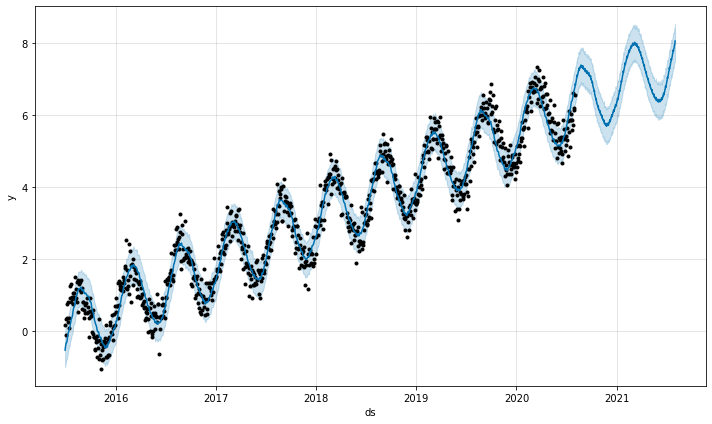

In [48]:
import matplotlib.pyplot as plt

fig_1 = model.plot(forecast) # plot the model

The black dots represent actual data points, while the blue line represents the 'yhat', and the faint blue shadowing represents the confidence intervals. Anything outside this would be considered an 'anomaly'. The individual components of the above plot can also be easily visualised using:

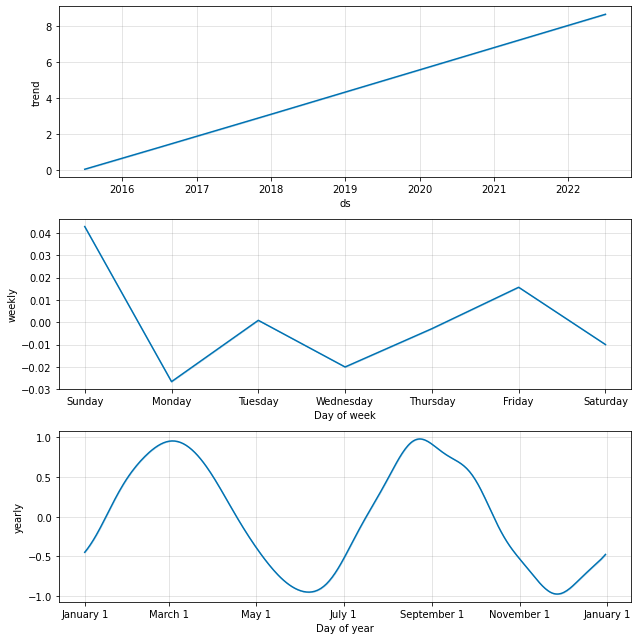

In [45]:
fig_2 = model.plot_components(forecast)

This is highly useful when exploring datasets, for it can provide you with interesting insight. In this case, we notice that the trend is as we expected, a straight line. To view how to extract the above information individually, double click this cell.

<!--

# to extract information from each plot, you must unpack the axes. The above is a matplotlib 'subplot' object.
# So:

plots = fig_2.get_axes()

# trend
x,y = plots[0].lines[0].get_data()

# weekly
x,y = plots[1].lines[0].get_data()

# yearly
x,y = plots[2].lines[0].get_data()

-->

# Seasonality

### Types of seasonality

Prophet really shines in how it allows you to control the seasonalities for the model. In the example above, this was done automatically as Prophet sets daily_seasonality, weekly_seasonality and yearly_seasnality to 'auto'. However, seasonality is more nuanced than this and may require you to manually set some options.

Recall the two different types of seasonalities:

Linear (default mode in Prophet)
$$y(t) = g(t) + s(t) + h(t) + \epsilon_t$$

Example:

<img style = "width:60%" src="Images/Additive_example.png">

Where $g(t)$ is the **trend**, $s(t)$ is the periodic signals (**seasons**), $h(t)$ is the **holiday effect** (this refers to irregular occuring events that cover a certain period of time) and $\epsilon_t$ which represents **noise**.

Multiplicative:

$$y(t) = g(t) \cdot s(t) \cdot h(t) \cdot \epsilon_t$$

Example:

<img style = "width:60%" src="Images/Multiplicative_example.png">

Changing this is very simple, and can be done by setting 'seasonality_mode = "multiplicative"'

In [49]:
m_multiplicative = Prophet(
    seasonality_mode = 'multiplicative'
)

m_additive = Prophet(
    seasonality_mode = 'additive' # set by default
)

# test on data
path = ''
df_multiplicative = pd.read_csv(path) 


fig = plt.figure()

### Holidays

In addition to different types of seasonality, Prophet allows users to set their own, custom seasonalities (i.e. quarterely seasonalities for example), or account for 'holidays'. Holidays can be quite important in analysis, because you might want to capture irregular occurances. 

For example, consider that you want to model the car usage in the UAE. Unlike in Europe, religious holidays are not fixed, since Eid (a Muslim holiday) is based on a lunar calendar, and thus moves back by 10 days every year with respect to the Gregorian calendar. In such a case, you would need to specify the dates of Eid, so that the Prophet model 'knows' that there will be spikes on those days.

But one must be careful when specifying holidays: in Europe for example, Christmas is a recurring holiday that happens on the same day, every year. As such, it would automatically get captured by the yearly seasonality. In that case, Prophet would add an extra 'holiday' effect on top of the yearly seasonality for Christmas.

### Fourier order of model


As such, it's always good practice to create a 'vanilla' Prophet model, and then add seasonalities manually.

<div style="color:red">Note about explaining how setting holidays separately might be a good thing?</div>

In [ ]:
model = Prophet()

# Code Break

# Model evaluation

# Saving and retrieving a Prophet model

In [1]:
# saving the model using pickle

# saving the model using json

# Other things that you can do with Prophet...

Due to time constraints, it was not possible to have an in depth and rigorous Prophet module. For more specific information regarding any of these topics, visit the Prophet website [2].

1. Trends

# Conclusive Remarks

Prophet is very powerful and easy to get started with. However, it's hard to get used to all of it's features and understand which ones to use. So continuous practice, as with everything, is always recommended.

It also does have weaknesses, and it's worth knowing what these are.

### Weaknesses of Prophet

Since we know Prophet's strengths, we can clearly identify weaknesses.

The greatest is perhaps the fact that Prophet requires lots of historical data. Further, one must note that for datasets that don't have a very clear seasonality, Prophet may not perform well. Prophet models also struggle with highly-skewed data.

Let's see an example of a difficult dataset:

<img style="width:60%" src="Images/Low_seasonality_data.png">
<center style="color: gray; font-style: italic">Time-series data of total gyration measured by an Arduino Nano BLE in a person's pocket.</center>

<div style="visibility:hidden"> https://github.com/namiyousef/Kin-Keepers/blob/master/Anomaly%20Detection%20in%20Significant%20Movements/Images/Ignacio_moving_average_1.png</div>

The blue dots are essentially time-series data (the orange being a moving average - don't worry about the fact that it's discontinuous as this is not relevant). As you can see from the blue dots, there is no clear seasonality. Further to this, the data collected is representative of ~ 4 days. To make matters more problematic, the data is highly high-skewed (you can see this on the graph by the proportion of points that are close to 0!). Such datasets are not suitable for Prophet. 

Another weakness of Prophet is it's functionality regarding daily seasonalities (i.e. when you have repetitive features every day); this, however, is out of the scope of this notebook.  

Now that you have an idea of what Prophet is, let's start playing!

# References

1. https://facebook.github.io/prophet/docs/quick_start.html#python-api
2. https://facebook.github.io/prophet/
3. https://medium.com/future-vision/intro-to-prophet-9d5b1cbd674e